In [1]:
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
base_url = "http://agbc-fe.pdn.ac.lk/api/v1/data/?sensor=10008&date="

start_date = pd.to_datetime("2020-10-22")
end_date = pd.to_datetime("2021-02-05")

date_range = pd.date_range(start=start_date, end=end_date, freq="D")

all_data = []

def fetch_data(date):
    date_str = date.strftime("%Y-%m-%d")
    url = base_url + date_str

    try:
        response = requests.get(url)
        data = response.json()
        return data['data']
    except:
        print(f"Error: Could not retrieve data for date {date_str}")
        return []

start_time = time.time()  # Get the current time before starting the execution


# Create a ThreadPoolExecutor with the maximum number of workers
executor = ThreadPoolExecutor(max_workers=None)

# Use tqdm to track the progress
with tqdm(total=len(date_range), desc="Progress", unit="day") as pbar:
    # Submit the fetch_data task to the executor for each date in parallel
    futures = [executor.submit(fetch_data, date) for date in date_range]
    
    # Retrieve the results from the completed futures
    for future in futures:
        all_data.extend(future.result())
        pbar.update(1)
    

end_time = time.time()  # Get the current time after finishing the execution
execution_time = end_time - start_time

print("Execution Time:", execution_time, "seconds")

# Create the DataFrame from the collected data
df = pd.DataFrame(all_data, dtype=str)
df.to_csv('dataws.csv', index=False)


Progress:   0%|          | 0/107 [00:00<?, ?day/s]

Error: Could not retrieve data for date 2020-10-31


Progress: 100%|██████████| 107/107 [00:20<00:00,  5.10day/s]


Execution Time: 20.98292088508606 seconds


In [3]:
# check for missing values
print(df.isnull().sum())

siteId       0
seqNo        0
date         0
time         0
temp1        0
temp2        0
temp3        0
humidity1    0
humidity2    0
humidity3    0
light        0
dtype: int64


In [4]:
# drop rows with missing values
df.dropna(inplace=True)

In [5]:
# Drop duplicate rows
df=df.drop_duplicates(keep='first')

In [6]:
import numpy as np
# Replace '?' with NaN

df.replace(' ?', np.nan, inplace=True)



print(df.tail(10))


       siteId  seqNo         date       time  temp1  temp2  temp3 humidity1   
257613      0   2869   2021-02-05   23:55:03    NaN   23.3     22       NaN  \
257614      0   2870   2021-02-05   23:55:31   22.2   23.3   22.1      99.9   
257615      0   2871   2021-02-05   23:56:03    NaN   23.3   22.2       NaN   
257616      0   2872   2021-02-05   23:56:31   22.2   23.3   22.1      99.9   
257617      0   2873   2021-02-05   23:57:05    NaN   23.3   22.1       NaN   
257618      0   2874   2021-02-05   23:57:31   22.2   23.3   22.1      99.9   
257619      0   2875   2021-02-05   23:58:01   22.2   23.3   22.1      99.9   
257620      0   2876   2021-02-05   23:58:33    NaN   23.3   22.2       NaN   
257621      0   2877   2021-02-05   23:59:01   22.3   23.3   22.2      99.9   
257622      0   2878   2021-02-05   23:59:31   22.3   23.3   22.2      99.9   

       humidity2 humidity3   light  
257613        95        95   1.042  
257614        95        95   1.042  
257615        95   

<h2>Create a new DataFrame with Average Temperature and Average Humidity Values </h2>

In [7]:
# Convert temperature columns to numeric
df['temp1'] = pd.to_numeric(df['temp1'], errors='coerce')
df['temp2'] = pd.to_numeric(df['temp2'], errors='coerce')
df['temp3'] = pd.to_numeric(df['temp3'], errors='coerce')

# Convert temperature columns to numeric
df['humidity1'] = pd.to_numeric(df['humidity1'], errors='coerce')
df['humidity2'] = pd.to_numeric(df['humidity2'], errors='coerce')
df['humidity3'] = pd.to_numeric(df['humidity3'], errors='coerce')

df['seqNo'] = pd.to_numeric(df['seqNo'], errors='coerce')

# Calculate the average temperature
df['average_internal_temp'] = df[['temp1', 'temp2', 'temp3']].mean(axis=1,skipna=True)

# Calculate the average humidity
df['average_internal_humidity'] = df[['humidity1', 'humidity2', 'humidity3']].mean(axis=1,skipna=True)

# Create a new DataFrame with only the desired columns
new_df = df[['seqNo','date','time','average_internal_temp', 'average_internal_humidity', 'light']]


print(new_df.head())



   seqNo         date       time  average_internal_temp   
0      1   2020-10-22   00:00:01              23.433333  \
1      2   2020-10-22   00:00:18              23.550000   
2      3   2020-10-22   00:00:31              23.433333   
3      4   2020-10-22   00:00:46              23.466667   
4      5   2020-10-22   00:01:01              23.400000   

   average_internal_humidity   light  
0                  96.300000   1.042  
1                  95.000000   1.042  
2                  96.266667   1.042  
3                  96.200000   1.042  
4                  96.166667   1.042  


<h2> Create a Data frame for Internal Sensor 10008 data </h2>

In [8]:
# Combine the 'date' and 'time' columns into a single datetime column
new_df['datetime'] = pd.to_datetime(new_df['date'] + ' ' + new_df['time'])
# Set the 'time' column as the DataFrame index
new_df.set_index('datetime', inplace=True)
new_df.drop(['date', 'time','seqNo'], axis=1, inplace=True)
# Resample the DataFrame using 'H' offset alias and select the first entry from each hour
new_df_hourly = new_df.resample('H').first()

# new_df_hourly.reset_index(inplace=True)
# Print the resulting DataFrame

new_df_hourly.to_csv('sensor10008.csv', index=False)

/var/folders/jc/5dgg62dn62g30jn00c_29n180000gn/T/ipykernel_74120/77695520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['datetime'] = pd.to_datetime(new_df['date'] + ' ' + new_df['time'])
/var/folders/jc/5dgg62dn62g30jn00c_29n180000gn/T/ipykernel_74120/77695520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(['date', 'time','seqNo'], axis=1, inplace=True)


<h2> Create a Data frame for External Environmental data </h2>

In [9]:
# Load the CSV file into a DataFrame
external_weather = pd.read_csv('weather_data.csv')

# Combine the 'Date' and 'Time' columns into a single datetime column
external_weather['datetime'] = pd.to_datetime(external_weather['Date'] + ' ' + external_weather['Time'])

external_weather.drop(["Time","Date"],axis=1,inplace=True)

external_weather.set_index('datetime', inplace=True)

merged_df = pd.merge(external_weather, new_df_hourly, on='datetime')

# Drop rows with any null values
merged_df.dropna(inplace=True)

merged_df.to_csv('data_set.csv')






In [10]:
# from pandas_profiling import ProfileReport

# # Create a profile report for your DataFrame
# profile = ProfileReport(merged_df)

# # Generate the report and save it as an HTML file
# profile.to_file('profile_report.html')

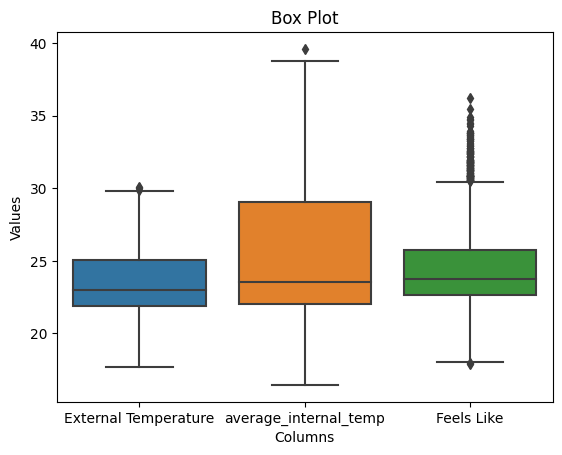

In [11]:
# Specify the columns for the box plot
columns_to_plot = ['External Temperature', 'average_internal_temp','Feels Like']

# Create the box plot using seaborn
sns.boxplot(data=merged_df[columns_to_plot])

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plot')

# Show the plot
plt.show()

<h2> Extracting features and target variable </h2>

In [12]:

from sklearn.model_selection import train_test_split


y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like','Pressure','External Humidity','Dew Point','Clouds','Wind Speed']]



<h2> Model Trained By  LinearRegression</h2>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate training accuracy
train_accuracy = model.score(X_train, y_train)

# Calculate test accuracy
test_accuracy = model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:",test_accuracy)

print(type(X_test))


Training Accuracy: 0.20506265366033047
Test Accuracy: 0.2194946874890945
<class 'pandas.core.frame.DataFrame'>


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Training the linear regression model
model =RandomForestRegressor()
model.fit(X_train, y_train)

# Calculate training accuracy
train_accuracy = model.score(X_train, y_train)

# Calculate test accuracy
test_accuracy = model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:",test_accuracy)

print(type(X_test))


NameError: name 'RandomForestRegressor' is not defined

<h2> Model Trained By  DecisionTree Regressor</h2>

In [16]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 629.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 952.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.4 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import optuna
# Assuming you have your input features in X and output features in y

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10)
    
    # Create the decision tree regressor object with the suggested parameters
    clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

    # Fit the model to the training data
    clf.fit(X_train, y_train)
    
    # Calculate the test accuracy
    test_accuracy = clf.score(X_test, y_test)
    
    return test_accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters from the study
best_params = study.best_params


clf = DecisionTreeRegressor(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'])
clf.fit(X_train, y_train)


print("Best Max Depth is : ",best_params['max_depth'])

print("Best Min Samples Leaf is : ",best_params['min_samples_leaf'])
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)



/Users/hari/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-06-07 14:00:33,466] A new study created in memory with name: no-name-5b0f694d-cb79-4f9e-80d6-67daf6641a19
[I 2023-06-07 14:00:33,477] Trial 0 finished with value: 0.3273795479235266 and parameters: {'max_depth': 5, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.3273795479235266.
[I 2023-06-07 14:00:33,483] Trial 1 finished with value: 0.27133909706523357 and parameters: {'max_depth': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.3273795479235266.
[I 2023-06-07 14:00:33,491] Trial 2 finished with value: 0.3387469228282489 and parameters: {'max_depth': 6, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.3387469228282489.
[I 2023-06-07 14:00:33,498] Trial 3 finished with value: 0.3088301767069687 and param

Best Max Depth is :  6
Best Min Samples Leaf is :  6
Training Accuracy: 0.458194059668301
Test Accuracy: 0.3525854920278177


<h2> Model Trained By Lasso</h2>

In [18]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming you have a pandas DataFrame 'data' containing your feature columns (X) and target column (y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create the Lasso regression model
lasso = Lasso(alpha=0.001)  # Adjust the alpha parameter to control the degree of regularization

# Fit the model to the training data
lasso.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
# Get the score (coefficient of determination) on the testing data
score = lasso.score(X_test, y_test)
print("Score:", score)

Mean Squared Error: 8253879.676310171
Score: 0.19409810053905932


<h2>Model Trained By Ridge regression </h2>

In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Assuming you have your feature matrix X and target variable y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but recommended for regularization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a Ridge regression model
ridge = Ridge(alpha=1.0)  # You can adjust the regularization strength by changing the alpha parameter

# Train the model
ridge.fit(X_train, y_train)

# Make predictions
y_pred = ridge.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 8257927.40880755
R2 Score: 0.19353924689866875


<h1>MLPRegressor</h1>

In [15]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [32]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import accuracy_score

# Assuming you have your feature matrix X and target variable y
y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like','Pressure','External Humidity','Dew Point','Clouds','Wind Speed']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#
# Create the model
model = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict the target values for the testing set
y_pred = model.predict(X_test)

# Evaluate the model
score = model.score(X_test, y_test)
print('Score:', score)

Score: 0.09521052312338134


<h1>RANDOM FOREST REGRESSOR</h1>

In [31]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import accuracy_score

# Assuming you have your feature matrix X and target variable y
y = merged_df[['average_internal_temp', 'average_internal_humidity', 'light']]
X = merged_df[['Feels Like','Pressure','External Humidity','Dew Point','Clouds','Wind Speed']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#
# Create the model
model =RandomForestRegressor(n_estimators=250, max_depth=10, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict the target values for the testing set
y_pred = model.predict(X_test)

# Evaluate the model
score = model.score(X_test, y_test)
print('Score:', score)


train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Score: 0.3940798806188008
Training Accuracy: 0.802251246125528
Test Accuracy: 0.3940798806188008


In [51]:
# **Simple neural network**

import tensorflow as tf
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

# Convert the X_train and y_train variables to type float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

X_train= tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train= tf.convert_to_tensor(y_train, dtype=tf.float32)

# Train the model
model.fit(X_train, y_train, epochs=1000)

# Evaluate the model
model.evaluate(X_test, y_test)

# **Deep neural network**

import tensorflow as tf

# Create the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Convert the X_train and y_train variables to type float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

# Train the model
model.fit(X_train, y_train, epochs=100)

# Evaluate the model
model.evaluate(X_test, y_test)


Epoch 1/1000


KeyboardInterrupt: 